Loading data

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

film_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 
                'unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 
                'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical', 'mystery', 
                'romance', 'sci-fi', 'thriller', 'war', 'western']
films = pd.read_csv('u.item', sep='[|]', names=film_columns, engine='python')
film_names = films[['movie_id', 'movie_title']]
film_genres = films.drop(['movie_id', 'movie_title', 'release_date', 'video_release_date', 
                          'imdb_url'], axis=1)
film_genres.head()


,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
1677,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1681,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [2]:
data_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=data_columns)
data = data.drop('timestamp', axis=1)
data.head()


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='[|]', names=user_columns, engine='python')
users = users.drop('zip_code', axis=1)
users.head()


,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


Elbow method for optimal number of clusters and films clustering

In [4]:
def ElbowMethod(data):
    distortion = []
    K = range(1, 25)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data)
        distortion.append(kmeanModel.inertia_)

    plt.plot(K, distortion, 'bx-')
    plt.xlabel('K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for films')
    plt.show()


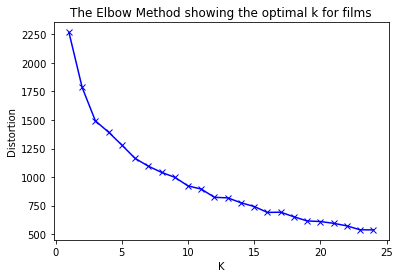

In [5]:
ElbowMethod(film_genres)

# clustering films
kmeans = KMeans(n_clusters=12, random_state=5).fit(film_genres)


Method for finding films from a certain cluster that are not rated by the user

In [6]:
def NotRatedFilms(cluster_id, labels, user_id, data, film_id):
    # films from same cluster (indexes of the array elements)
    films_from_cluster = [i for i, e in enumerate(labels) if e == cluster_id and i != film_id - 1]
    # increment indexes to get ids of the films
    films_from_cluster = [x + 1 for x in films_from_cluster]
    
    # films from the cluster rated by the user
    rated = data[(data.user_id == user_id) & (data.movie_id.isin(films_from_cluster))]
    rated_films = rated['movie_id'].values
    
    recommended = []
    for i in films_from_cluster:
        if i not in rated_films:
            recommended.append(i)
    
    return recommended


Recommending films to a user based on currently watching

In [7]:
user_id = 6
film_id = 94

# find cluster to which film belongs
cluster = kmeans.labels_[film_id - 1]

# recommend films from the same cluster
recommended = NotRatedFilms(cluster, kmeans.labels_, user_id, data, film_id)

print("Recommended films:")
for i in range(0, 10):
    print(films['movie_title'].values[recommended[i] - 1])


Recommended films:

Get Shorty (1995)


Birdcage, The (1996)


Brothers McMullen, The (1995)


Doom Generation, The (1995)


To Wong Foo, Thanks for Everything! Julie Newmar (1995)


Billy Madison (1995)


Clerks (1994)


Eat Drink Man Woman (1994)


Santa Clause, The (1994)


What's Eating Gilbert Grape (1993)




Recommending films from the best rated cluster for a user

In [8]:
pd.options.mode.chained_assignment = None
# adding cluster column to films data frame
film_names['cluster'] = kmeans.labels_

# selecting rated films by the user
rated_films = data[data.user_id == user_id]

# combining rated films with cluster number
rated_films_clusters = pd.merge(rated_films, film_names, on='movie_id')

# calculating average rating for each cluster
cluster_ratings = rated_films_clusters.groupby(['cluster'], as_index=False)['rating'].mean()

cluster_ratings.head()


Recommended films:

Four Rooms (1995)


Seven (Se7en) (1995)


Net, The (1995)


Wallace & Gromit: The Best of Aardman Animation (1996)


Basic Instinct (1992)




In [ ]:
# get best rated cluster
best_rated_cluster = cluster_ratings['cluster'].values[cluster_ratings['rating'].idxmax()]

# recommending films from the best rated cluster
recommended = NotRatedFilms(best_rated_cluster, kmeans.labels_, user_id, data, -1)

print("Recommended films:")
for i in range(0, 5):
    print(films['movie_title'].values[recommended[i] - 1])


Recommending similar movies using matrix factorization

In [9]:
# build a utility matrix with a value for each user and each movie (0 if not rated)
rating_crosstab = data.pivot_table(values='rating', index='user_id', columns='movie_id', 
                                   fill_value=0)
# transpose matrix so that movies are represented by rows
film_rating = rating_crosstab.T

film_rating.head()


Home Alone (1990)
Recommended films:



['Santa Clause, The (1994)',
 'Mask, The (1994)',
 'Maverick (1994)',
 'Mrs. Doubtfire (1993)',
 'Three Musketeers, The (1993)',
 "City Slickers II: The Legend of Curly's Gold (1994)",
 'Son in Law (1993)',
 'Renaissance Man (1994)']

In [ ]:
# use singular value decomposition
SVD = TruncatedSVD(n_components=12, random_state=17)

# use fit method to perform SVD on 'film_rating'
resultant_matrix = SVD.fit_transform(film_rating)

# calculate Pearson correlation for all movies
corr_mat = np.corrcoef(resultant_matrix)

corr_mat[:5, :5]


In [ ]:
# recommend movies related to a certain movie
# extract correlation of film
corr_film = corr_mat[film_id - 1]

# generate a list of movie names that have a high degree of correlation with target
print("Recommended films:")
list(films['movie_title'].values[(corr_film < 1.0) & (corr_film > 0.95)])


Recommending movies using kNN

In [ ]:
genres = ['action', 'adventure', 'crime', 'mystery']
target = film_genres[genres]

# use fit method to create model
neighbors = NearestNeighbors(n_neighbors=5).fit(target)

# check the recommendation by model
print("Recommended films:")
for i in neighbors.kneighbors([[1, 1, 1, 1]], return_distance=False)[0]:
    print(films['movie_title'].values[i])


Solving cold start problem using random forest

In [ ]:
# combining rated films with cluster numbers
rated_films_clusters = pd.merge(data, film_names, on='movie_id')

# calculating average rating for each user and cluster
cluster_ratings = rated_films_clusters.groupby(['user_id', 'cluster'], as_index=False)['rating']\
    .mean()

cluster_ratings.head()


In [ ]:
# finding best rated cluster for each user
idx = cluster_ratings.groupby(['user_id'], as_index=False)['rating'].idxmax()
cluster_ratings = cluster_ratings.loc[idx]

# combine user info and best rated cluster info
users_clusters = pd.merge(users, cluster_ratings, on='user_id')
users_clusters = users_clusters.drop(['user_id', 'rating'], axis=1)

users_clusters.head()


In [ ]:
# change categorical information into numerical information
categorical_features = ['gender', 'occupation']
for col in categorical_features:
        one_hot = pd.get_dummies(users_clusters[col])
        column_list = []
        for c in one_hot.columns:
            column_list.append(col + '_' + str(c))
        one_hot.columns = column_list
        users_clusters = users_clusters.drop(col, axis=1)
        users_clusters = users_clusters.join(one_hot)

users_clusters.head()


In [ ]:
# assign input and output variables
X = users_clusters.drop('cluster', axis=1)
y = users_clusters['cluster']

# create an instance of the classifier
rfc = RandomForestClassifier(n_estimators=800)

# fit the model on training set
rfc.fit(X, y)

# make prediction
user = [23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

# predict cluster for user and recommend films from it
prediction = rfc.predict([user])
recommended = NotRatedFilms(prediction, kmeans.labels_, -1, data, -1)

print("Recommended films:")
for i in range(0, 10):
    print(films['movie_title'].values[recommended[i] - 1])
